# Explainable AI con algoritmi genetici

## Naive implementation

Si mette il focus su problemi di classificazione o, per essere più precisi,
sui classificatori stessi.

Non è infatti di nostro interesse se la classificazione sia corretta o meno,
ci interessa sapere:

- "Perché" i dati sono stati classificati in quel modo.
- Come modificare i dati in modo che varino il meno possibile ma vengano
  classificati in modo differente.

L'esempio più banale che può venirci in mente è un problema di classificazione
in cui ogni punto ha due sole feature e due possibili classi. Andiamo quindi a
generare un dataset con queste caratteristiche e alleniamo classificatore.


<Figure size 640x480 with 0 Axes>

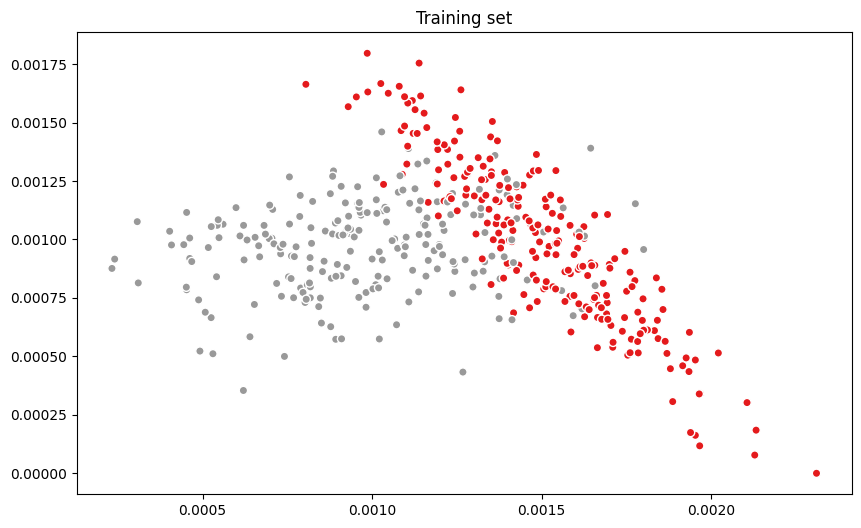

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from sklearn import preprocessing


X_train = np.load("datasets/X_train.npy", allow_pickle=True)
y_train = np.load("datasets/y_train.npy", allow_pickle=True)
X_test = np.load("datasets/X_test.npy", allow_pickle=True)

X_train = X_train + np.abs(np.min(X_train))
X_test = X_test + np.abs(np.min(X_test))

X_train = X_train / np.sum(X_train)
X_test = X_test / np.sum(X_test)

train_coords = X_train.T

plt.set_cmap("Set1")
plt.figure(figsize=(10, 6))
plt.title("Training set")
plt.scatter(train_coords[0], train_coords[1], c=y_train, ec="w")
plt.show()

Abbiamo quindi generato un training set e un test set su cui allenare e testare
il modello rispettivamente.

In realtà a noi non interessa per il momento testare la correttezza del modello
ma solo usare dati non presenti in fase di training per ciò che andremo a fare
dopo.

Proseguiamo quindi con l'allenamento del modello e la classificazione dei nuovi
punti i quali diventeranno il dataset di riferimento.


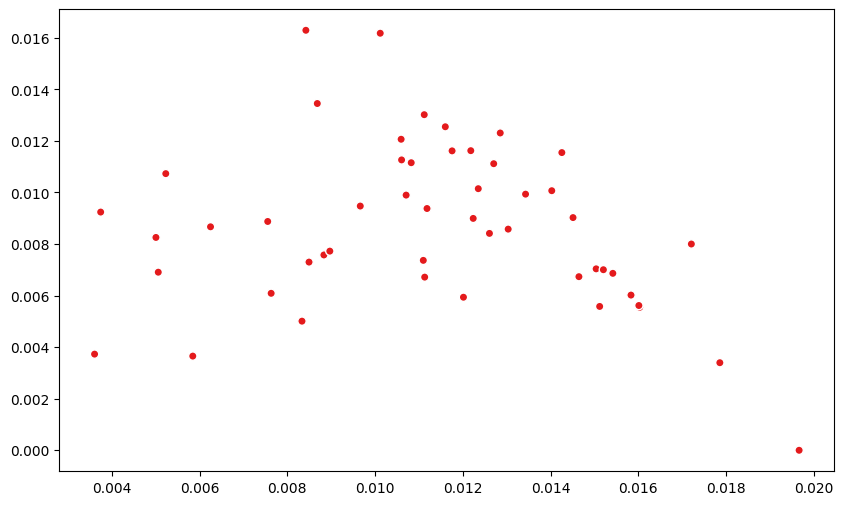

In [2]:
from sklearn.neural_network import MLPClassifier

import warnings

warnings.filterwarnings("ignore")

classifier = MLPClassifier(max_iter=2000)
classifier.fit(X_train, y_train)
y_predicted = classifier.predict(X_test)

test_coords = X_test.T

plt.figure(figsize=(10, 6))
plt.scatter(test_coords[0], test_coords[1], c=y_predicted, ec="w")
plt.show()

A questo punto prendiamo a caso uno dei punti classificati, di seguito
evidenziato in verde


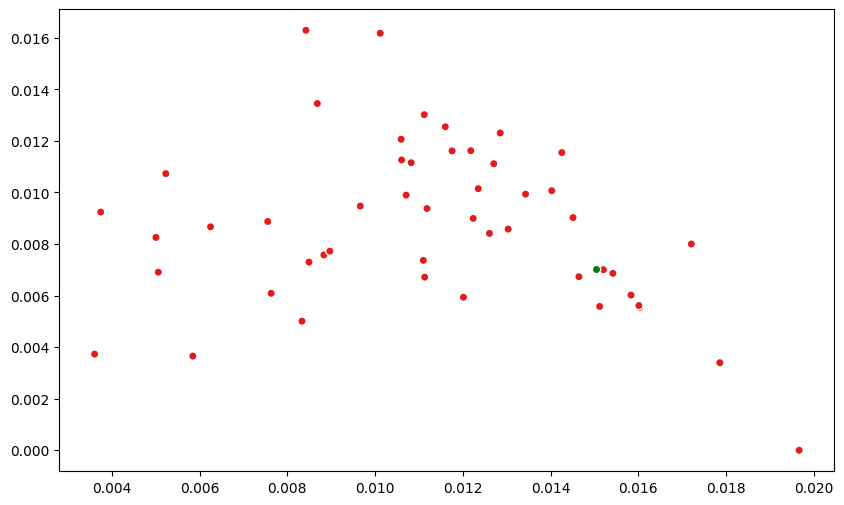

In [3]:
plt.figure(figsize=(10, 6))
plt.scatter(test_coords[0], test_coords[1], c=y_predicted, ec="w")

point = X_test[0]
point_class = y_predicted[0]

plt.scatter(point[0], point[1], c="g", ec="w")
plt.show()

e proseguiamo con la fase di explaining tramite un algoritmo genetico.


## Algoritmo genetico

L'algoritmo genetico prevede di analizzare ogni singolo punto un numero di
volte pari al numero delle classi possibili (nel nostro caso 2).

Andremo a definire due approcci volti a risolvere due problemi differenti:

1. spiegare perché quel punto è stato classificato in un
   determinato modo.
2. il secondo per capire come modificare le feature di quel punto il meno
   possibile per riuscire a classificarlo in tutte le altre possibili classi.

Nel nostro caso abbiamo una sola possibile altra classe ma nel caso ne avessimo
di più il metodo sarebbe lo stesso, basta cambiare la classe target di arrivo.

### Struttura del cromosoma

Prima di passare alla generazione della popolazione definiamo che forma
dovrebbe avere il cromosoma.

Dato che in entrambe le casistiche che vogliamo analizzare abbiamo bisogno di
sapere le feature di ogni individuo ma abbiamo anche bisogno di sapere come è
stato classificato il modo più naturale è quello di avere una coppia formata
da un vettore di feature e da un valore che indica la sua classe. Nel nostro
caso un numpy array e un numero intero rispettivamente.

### Generazione della popolazione iniziale

Come in ogni algoritmo genetico c'è bisogno di andare a generare una
popolazione iniziale. Nel nostro caso abbiamo bisogno che la popolazione
iniziale sia generata in modo che i nuovi individui siano simili a quello di
riferimento.

Per riuscire a generare una popolazione con queste caratteristiche possiamo
sfruttare la deviazione standard di ogni feature per generare un offset
verosimile con il dataset che stiamo considerando.


In [4]:
sigma = X_test.std(axis=0)
sigma

array([0.00372061, 0.00314731])

Per generare punti sintetici intorno a quello di riferimento usiamo due
possibili distribuzioni

- **Uniforme**: nella generazione di punti tramite distribuzione uniforme si
  ottiene una popolazione sintetica equamente distribuita entro un "raggio" che
  corrisponde ad una frazione $\tau$ della deviazione standard di entrambe le
  feature. Avremo quindi uno spazio di valori per le feature sintetiche di
  questo tipo:
  $$[-\sigma_i \cdot \tau, \; \sigma_i \cdot \tau]$$
  dove $\sigma_i$ è la deviazione standard dell'$i$-esima feature rispetto
  a tutta la popolazione.
- **Normale**: in modo simile possiamo usare una distribuzione normale centrata
  nel valore della feature e usare sempre una frazione della deviazione
  standard piccola a piacere. Avremo quindi una distribuzione del tipo:
  $$N(x_i, \; \sigma_i \cdot \tau)$$
  in cui $x_i$ è il valore dell'$i$-esima feature e $\sigma_i$ la sua
  deviazione standard.

Una distribuzione normale dovrebbe avere il vantaggio di riuscire a scalare
con la stessa dispersione che ha popolazione intera, mantenendo le
caratteristiche delle distribuzione di punti iniziale.

Una distribuzione uniforme invece riempe uno spazio arbitrariamente grande e
ben definito intorno al punto di riferimento.


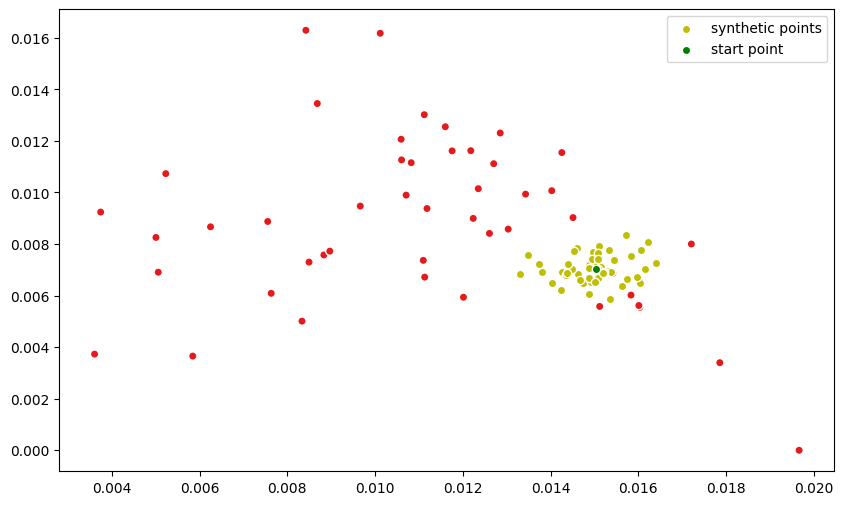

In [5]:
import numpy as np
from numpy import random as rnd
from ppga import base


def generate_normal(point, sigma, eta):
    return [rnd.normal(point, eta * sigma, size=(2,)), 0]


def generate_uniform(point, sigma, eta):
    return [rnd.uniform(point - sigma * eta, point + sigma * eta, size=(2,)), 0]


toolbox = base.ToolBox()
toolbox.set_generation(generate_normal, point=point, sigma=sigma, eta=0.15)

# generazione di una popolazione composta da 50 individui
population = toolbox.generate(50)
synth_points = np.array([i.chromosome[0] for i in population])

plt.figure(figsize=(10, 6))
plt.scatter(test_coords[0], test_coords[1], c=y_predicted, ec="w")
plt.scatter(
    synth_points.T[0], synth_points.T[1], c="y", ec="w", label="synthetic points"
)
plt.scatter(point[0], point[1], c="g", ec="w", label="start point")

plt.legend()
plt.show()

Come possiamo vedere gli individui sintetici generati si dispongono intorno
al punto di partenza considerato.

### Funzione di valutazione

L'altro parametro fondamentale è la funzione di valutazione del valore di
fitness di ciascun individuo sintetico. Nello specifico andiamo a definire
due funzioni di valutazione differenti.

- La prima funzione ci serve nel caso in cui si voglia rimanere nella stessa
  classe del punto di riferimento. Questa funzione dovrebbe premiare i punti
  vicini al punto di partenza ma classificati diversamente. Al contrario
  dovrebbe penalizzare punti simili al punto di partenza e classificati in
  allo stesso modo.
- L'altra funzione di valutazione dovrebbe invece valutare meglio individui
  classificati in una classe target di nostro interesse ma che rimangono
  vicini al punto di partenza. L'obbiettivo qui è andare a definire il
  confine tra le due classi.

Il valore di fitness in sé viene invece dato dalla distanza euclidea tra i
due punti. Tale distanza viene trattata e manipolata diversamente a seconda
di quale caso stiamo trattando e alla classificazione del punto sintetico.

#### Stessa classe

Nel caso si voglia rimanere all'interno della stessa classe si l'idea è quella 
di andare a costruire un boundary più generico che tiene i punti sintetici sul
confine di classificazione di ogni altra classe.

Vogliamo quindi allontanare i punti fin tanto che sono classificati nella stessa
classe del punto originale per poi riavvicinarli una volta cambiata la classe per
riportarli dentro al confine.

La funzione di valutazione diventa quindi

$$
f(x_i) = \begin{cases}
    \frac{1}{1 + e^{d(x_0, x_i)}} & \text{se } C_0 = C_i \\
    d(x_0, x_i) & \text{altrimenti}
\end{cases}
$$

dove $x_0$ e $C_0$ sono rispettivamente il vettore delle feature e la classe del 
punto iniziale, mentre $x_i$ e $C_i$ sono rispettivamente le feature e la classe 
dell'$i$-esimo punto sintetico.

In [6]:
from numpy import linalg as la
import scipy as sp

def same_evaluate(chromosome, point, point_class, classifier):
    # classificazione
    features, _ = chromosome
    features = features.reshape(1, -1)
    chromosome[1] = classifier.predict(features)

    # calcolo della distanza con norma euclidea
    distance = la.norm(point - features, ord=2)

    if chromosome[1] == point_class:
        return (sp.special.softmax(distance),)
    else:
        return (distance,)

toolbox.set_weights((-1.0,))
toolbox.set_evaluation(same_evaluate, point, point_class, classifier)
population = list(map(toolbox.evaluate, population))

Andiamo quindi a vedere come sono stati classificati i punti sintetici e 
di modo da capire come si è comportata la funzione di valutazione.

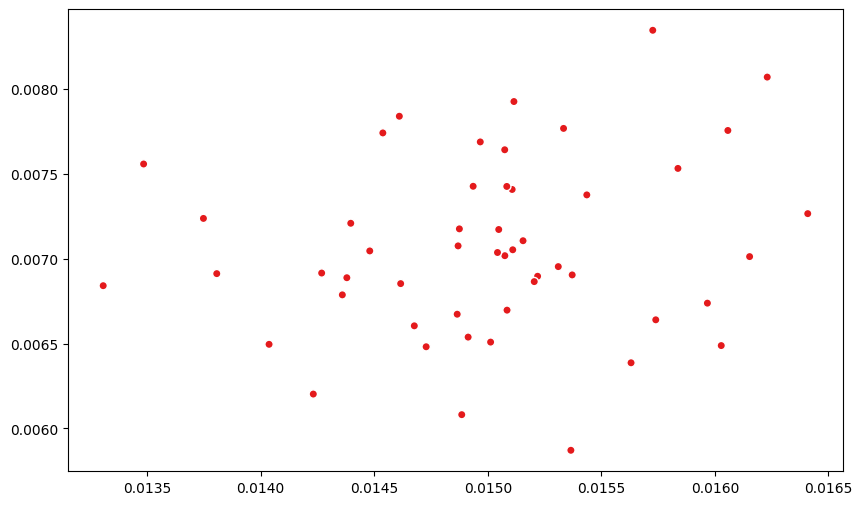

In [7]:
classes = [i.chromosome[1] for i in population]
plt.figure(figsize=(10, 6))
plt.scatter(synth_points.T[0], synth_points.T[1], c=classes, ec="w")
plt.scatter(X_test.T[0][0], X_test.T[1][0], c=y_predicted[0], ec="w")
plt.show()

Vediamo quindi come sono stati valutati in funzione della loro classificazione
e distanza dal punto d'origine.

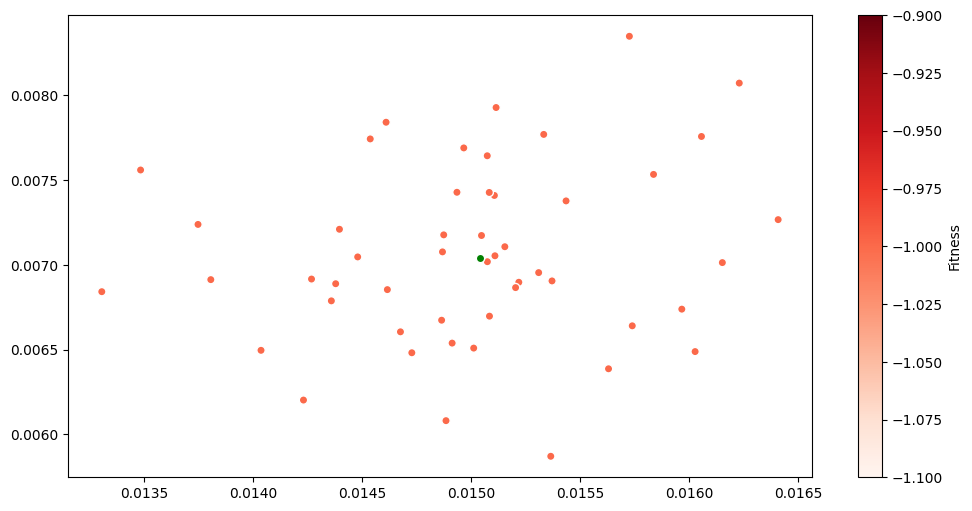

In [8]:
fitness_values = [i.fitness for i in population]
plt.figure(figsize=(12, 6))
sc = plt.scatter(
    synth_points.T[0],
    synth_points.T[1],
    c=fitness_values,
    ec="w",
    cmap=plt.get_cmap("Reds"),
)
plt.colorbar(sc, label="Fitness")
plt.scatter(X_test.T[0][0], X_test.T[1][0], c="g", ec="w")
plt.show()

#### Cambio di classe

Andiamo ora a costruire una funzione di fitness di modo da premiare
gli individui che riescono ad essere classificati in una classe target
differente da quella di partenza.

In questo caso abbiamo una funzione con un comportamento leggermente
differente:

$$ 
f(x_i) = \begin{cases}
    1 / d(x_0, x_i) & \text{se } C_i \neq C_t \\
    d(x_0, x_i) & \text{altrimenti}
\end{cases}
$$

dove $C_t$ è la classe target a cui stiamo cercando di arrivare.

In [9]:
def other_evaluate(chromosome, point, target_class, classifier):
    # classificazione
    features, _ = chromosome
    features = features.reshape(1, -1)
    chromosome[1] = classifier.predict(features)

    # calcolo della distanza con norma euclidea
    distance = la.norm(point - features, ord=2)

    if chromosome[1] != target_class:
        return (1 / distance,)
    else:
        return (distance,)

toolbox.set_weights((-1.0,))
toolbox.set_evaluation(other_evaluate, point, point_class + 1 % 2, classifier)
population = list(map(toolbox.evaluate, population))

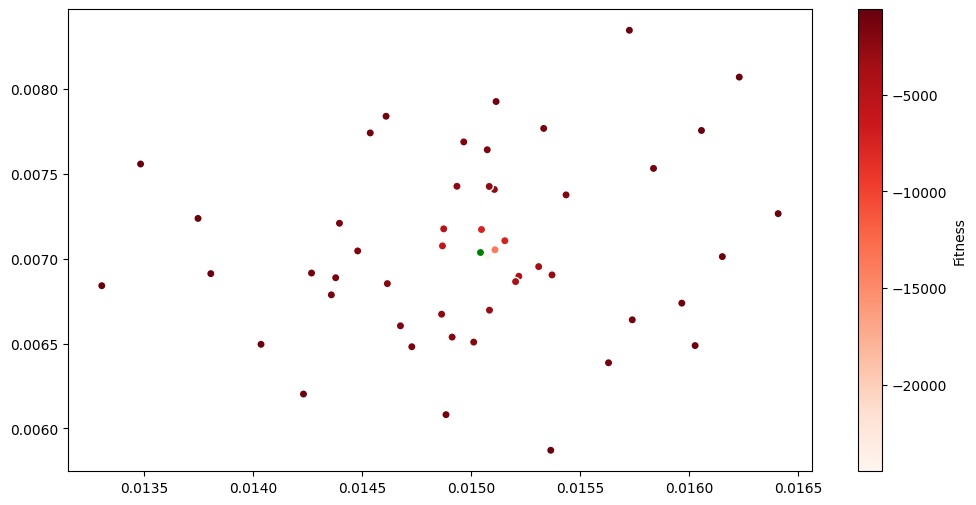

In [10]:
fitness_values = [i.fitness for i in population]
plt.figure(figsize=(12, 6))
sc = plt.scatter(
    synth_points.T[0],
    synth_points.T[1],
    c=fitness_values,
    ec="w",
    cmap=plt.get_cmap("Reds"),
)
plt.colorbar(sc, label="Fitness")
plt.scatter(X_test.T[0][0], X_test.T[1][0], c="g", ec="w")
plt.show()

### Crossover

Gli operatori di crossover da testare sono principalmente due:

- **One point** o **Two Points**: questi due operatori andrebbero
  a mischiare le feature dei due individui lasciandole invariate,
  sarà poi compito dell'operatore di mutazione effettuare variazioni
  sui valori stessi.
- **Media e fattore stocastico**: in alternativa si potrebbero creare
  due figli le cui feature sono la media delle feature dei genitori.
  Dato che sarebbero due figli uguali si potrebbe aggiungere un termine
  casuale per differenziarli. In alternativa si potrebbe generare un
  solo figlio da ogni coppia.

In [11]:
import random


def one_point(father, mother):
    ffeatures = father[0]
    mfeatures = mother[0]

    cx_point = random.randint(1, len(ffeatures) - 1)

    offspring1 = [np.append(ffeatures[:cx_point], mfeatures[cx_point:]), 0]
    offspring2 = [np.append(mfeatures[:cx_point], ffeatures[cx_point:]), 0]

    return offspring1, offspring2


toolbox.set_crossover(one_point)
o1, o2 = toolbox.crossover(population[0], population[1])
print(o1)
print(o2)

[array([0.01563082, 0.00648841]), 0]: 0.0
[array([0.01602798, 0.00638704]), 0]: 0.0


### Mutazione

L'operatore di mutazione si occuperà di andare a ad aggiungere un
fattore stocastico che, come per la generazione proviene da una 
gaussiana la cui deviazione standard è una frazione della deviazione
standard globale.